Урок 9. Инструменты разметки наборов данных
Задание 1.
Выберите датасет, который имеет отношение к вашей области интересов или исследований. Датасет должен содержать неструктурированные данные, требующие разметки для решения конкретной задачи, например, анализа настроений или распознавания именованных сущностей.

Задание 2.
Выполните разметку на основе правил (rule-based labeling) на подмножестве выбранного датасета. Разработайте и реализуйте набор правил или условий, которые позволят автоматически присваивать метки данным на основе определенных шаблонов или критериев.

Задача 3.
Выполните разметку вручную отдельного подмножества выбранного датасета с помощью выбранного вами инструмента разметки.

Задача 4.
Объедините данные, размеченные вручную, с данными, размеченными на основе правил. Объедините два подмножества размеченных данных в один набор данных, сохранив при этом соответствующую структуру и целостность.

Задача 5.
Обучите модель машинного обучения, используя объединенный набор размеченных данных. Разделите датасет на обучающий и тестовый наборы и используйте обучающий набор для обучения модели.

Задача 6.
Оценить эффективность обученной модели на тестовом датасете. Используйте подходящие метрики оценки. Интерпретируйте результаты и проанализируйте эффективность модели в решении задачи разметки.

In [109]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

Рассмотрим датасет Анализа финансовых новостей. https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis
Датасет представляет собой 5842 новости с оценкой настроения

In [110]:
# загрузим датасет и посмотри первые 5 строчек
df = pd.read_csv('./data.csv', engine='python', encoding='UTF-8', on_bad_lines='skip')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [111]:
le = LabelEncoder()
# заменим строковые значения настроения на числовые метки и запишем их в отдельный столбец
df['label'] = le.fit_transform(df['Sentiment'].astype(str))

In [112]:
df.head()

,Sentence,Sentiment,label
0,The GeoSolutions technology will leverage Bene...,positive,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,0
2,"For the last quarter of 2010 , Componenta 's n...",positive,2
3,According to the Finnish-Russian Chamber of Co...,neutral,1
4,The Swedish buyout firm has sold its remaining...,neutral,1


<Axes: >

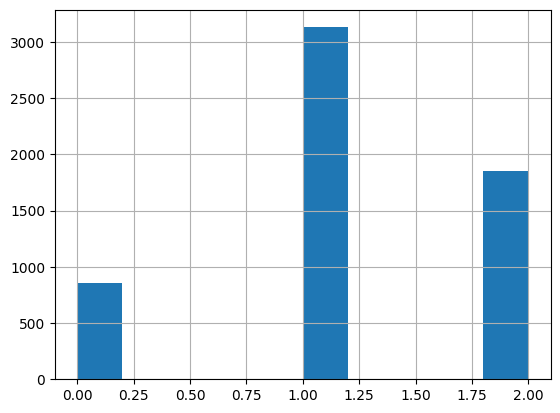

In [113]:
# посмотрим соотношение меток
df['label'].hist()

In [114]:
# перемешаем данные
df = shuffle(df)
# разделим их на тренировочные и тестовые
labeled_reviews, unlabeled_reviews = train_test_split(df, train_size=0.3, random_state=42)

In [115]:
labeled_reviews.head()

,Sentence,Sentiment,label
2056,"$AAPL Taking out the shorts here, a punishing ...",positive,2
1602,$RCON some upside today. This thing is severe ...,positive,2
3147,@ACInvestorBlog: $SPY eod run :),positive,2
1184,UPDATE 3-Auto Trader shares leap in UK's bigge...,positive,2
2760,Around 50 percent of the world 's ro-ro fleet ...,neutral,1


In [116]:
unlabeled_reviews.head()

,Sentence,Sentiment,label
1531,Investors will continue being interested in th...,positive,2
2170,"In 2010 , Sanoma Magazines expects net sales t...",neutral,1
1459,When this information was released on 5 Septem...,neutral,1
3323,HSBC Hit by Fresh Details of Tax Evasion Claims,negative,0
4638,"industry in Asia +ó Pakistan , Malaysia , Taiw...",neutral,1


In [117]:
# определим функцию для обучения модели
def train_model(labeled_data):
    vect = TfidfVectorizer()
    x = vect.fit_transform(labeled_data['Sentence'])
    y = labeled_data['label']
    model = LogisticRegression()
    model.fit(x, y)
    return model, vect

In [118]:
# произведем обучение начальной модели на тренировочных данных
model, vect = train_model(labeled_reviews)

In [119]:
# применим модель к тестовым данным для получения прогнозируемых значений
x_unlabeled = vect.transform(unlabeled_reviews['Sentence'])
y_unlabeled_pred = model.predict(x_unlabeled)

In [120]:
# вычислим энтропию предсказаний
y_unlabeled_proba = model.predict_proba(x_unlabeled)
uncertainly = - (y_unlabeled_proba * np.log2(y_unlabeled_proba)).sum(axis=1)

In [121]:
uncertainly

array([0.93260984, 1.37761855, 0.94267715, ..., 1.16479042, 0.9955957 ,
       1.15636081])

In [122]:
# выберем 100 наиболее неопределенных данных и отдадим их человеку для маркировки вручную
labeled_reviews_new = unlabeled_reviews.iloc[uncertainly.argsort()[:100]]
unlabeled_reviews_new = unlabeled_reviews.iloc[uncertainly.argsort()[100:]]                                     

In [123]:
labeled_reviews_new

,Sentence,Sentiment,label
4223,The value of the contract is in total USD12m .,neutral,1
183,"The company is headquartered in Sievi , Finlan...",neutral,1
4807,The value of the total investment is about EUR...,neutral,1
2377,The total value of the agreement is USD4 .0 m ...,neutral,1
3498,The value of the contract is about EUR 27mn .,neutral,1
...,...,...,...
4233,The second company acquired is Sweden 's Refte...,neutral,1
334,"The firm is headquartered in Vantaa , southern...",neutral,1
1785,The shares subscribed for under the stock opti...,neutral,1
273,The Efore plant at Saarijarvi in central Finla...,neutral,1


In [124]:
# соединим размеченные человеком данные с тренировочным множеством
labeled_reviews = pd.concat([labeled_reviews, labeled_reviews_new])
labeled_reviews

,Sentence,Sentiment,label
2056,"$AAPL Taking out the shorts here, a punishing ...",positive,2
1602,$RCON some upside today. This thing is severe ...,positive,2
3147,@ACInvestorBlog: $SPY eod run :),positive,2
1184,UPDATE 3-Auto Trader shares leap in UK's bigge...,positive,2
2760,Around 50 percent of the world 's ro-ro fleet ...,neutral,1
...,...,...,...
4233,The second company acquired is Sweden 's Refte...,neutral,1
334,"The firm is headquartered in Vantaa , southern...",neutral,1
1785,The shares subscribed for under the stock opti...,neutral,1
273,The Efore plant at Saarijarvi in central Finla...,neutral,1


In [125]:
# переобучим модель уже на новых данных
model, vectorized = train_model(labeled_reviews)

In [126]:
reviews_test = unlabeled_reviews
reviews_test

,Sentence,Sentiment,label
1531,Investors will continue being interested in th...,positive,2
2170,"In 2010 , Sanoma Magazines expects net sales t...",neutral,1
1459,When this information was released on 5 Septem...,neutral,1
3323,HSBC Hit by Fresh Details of Tax Evasion Claims,negative,0
4638,"industry in Asia +ó Pakistan , Malaysia , Taiw...",neutral,1
...,...,...,...
4089,Scanfil will execute the temporary lay-offs by...,neutral,1
1302,"In the Baltic countries , Atria 's target is o...",neutral,1
607,"Cargotec Corporation , Press Release , August ...",positive,2
5328,"Cencorp would focus on the development , manuf...",neutral,1


оценима качество модели на тестовом датасете

In [127]:
x_test = vectorized.transform(reviews_test['Sentence'])
x_test

<4090x6043 sparse matrix of type '<class 'numpy.float64'>'
	with 60757 stored elements in Compressed Sparse Row format>

In [128]:
y_test_pred = model.predict(x_test)
y_test_pred

array([1, 1, 1, ..., 1, 1, 1])

In [129]:
f1 = f1_score(reviews_test['label'], y_test_pred, average='weighted')
f1

0.6397590351957971

Вывод. Была проведена работа с датасетом, в частности:
* разделение данные на тренировочные  и тестовые, 
* предварительное обучение модели, 
* внесение изменений в метки данных, 
* добавление новых данных в обучающую выборку, 
* обучение модели на новых данных, оценка качества модели. <br><br>
Эффективность модели составила 64%